In [1]:
"""
Video & Audio Confidence Classification Pipeline (without Py‑Feat)
---------------------------------------------------------------

This script implements a complete pipeline for classifying interview videos
into three confidence classes (0, 1, 2) using only two modalities:

* **Video** – frame‑level visual information processed by a pre‑trained
  VideoMAE model.  VideoMAE is a masked autoencoder trained on video data
  and can be used to extract meaningful visual representations for
  downstream tasks【484109513959923†screenshot】.
* **Audio** – speech information processed by a pre‑trained WavLM model.
  WavLM is a large‑scale self‑supervised speech model that operates on
  16 kHz audio and outputs latent speech representations suitable for
  tasks like classification or speaker identification【351022628542233†L67-L74】.

This pipeline follows these steps:

1. **Environment setup** – installs any missing packages using pip and
   suppresses common ALSA/XDG warnings when decoding audio.  We avoid
   pinning versions of SciPy/Numpy to avoid conflicts with Kaggle’s
   preinstalled packages, and we patch SciPy if necessary.
2. **Dataset discovery** – automatically locates the dataset under
   `/kaggle/input` with the structure `videos/videos` and a CSV file
   mapping video filenames to labels.
3. **Clip generation** – each video is split into 10‑second clips.  If a
   remainder shorter than 10 seconds exists and there are more than five
   clips, the remainder is dropped; otherwise it is padded.  If fewer
   than five clips are available, we create additional clips using safe
   augmentations (brightness, contrast, crop, jitter) until we have
   exactly five clips.
4. **Feature extraction** – for each clip, we extract 16 evenly spaced
   frames and compute a VideoMAE embedding.  We also extract the
   corresponding 10‑second audio segment and compute a WavLM embedding.
   For each video, we average the per‑clip embeddings and concatenate the
   resulting VideoMAE and WavLM vectors to form a single fused feature
   vector.
5. **Caching** – fused embeddings are cached to `/kaggle/working/cache` to
   avoid recomputing features across cross‑validation folds.
6. **Classification** – we train a small multilayer perceptron (MLP) with
   one hidden layer using five‑fold stratified cross‑validation.  All
   metrics (mean absolute error, quadratic weighted kappa, accuracy,
   Spearman correlation and expected calibration error) are printed per
   fold along with confusion matrices and compared against baseline
   values.

The Py‑Feat facial feature extraction module has been removed in this
version because its installation introduces conflicting dependencies in
Kaggle environments.  The resulting pipeline uses only visual and
acoustic features but retains the same clip policy and training logic.

To run this script in a Kaggle notebook:

1. Copy the contents of this file into a cell in your notebook.
2. Run the cell.  The script will install any missing packages and
   automatically locate the dataset.  Progress messages will indicate
   when each stage is complete.

Note: the pre‑trained models are loaded in evaluation mode and their
weights are not updated during training.  Only the classification head
learns to map fused features to class labels.
"""

import os
import sys
import subprocess
import importlib
import warnings
import glob
import math
import random
from typing import List, Tuple

warnings.filterwarnings("ignore")

In [2]:
# -----------------------------------------------------------------------------
# 1) Environment setup
# -----------------------------------------------------------------------------

# Silence XDG/ALSA warnings that often appear when decoding audio in headless
# environments such as Kaggle.  This prevents clutter in the output.
os.environ.setdefault("XDG_RUNTIME_DIR", "/tmp/runtime-root")
os.makedirs(os.environ["XDG_RUNTIME_DIR"], exist_ok=True)
os.environ.setdefault("SDL_AUDIODRIVER", "dummy")


def ensure(pkg: str, import_name: str = None, min_version: str = None) -> None:
    """Install a Python package if it is missing or older than `min_version`.

    Parameters
    ----------
    pkg : str
        Name of the package to install via pip.
    import_name : str, optional
        Name used to import the package.  If None, defaults to `pkg`.
    min_version : str, optional
        Minimum acceptable version.  If the installed package version is
        older than this, it will be upgraded.
    """
    name = import_name or pkg
    try:
        mod = importlib.import_module(name)
        if min_version:
            from importlib.metadata import version, PackageNotFoundError
            from packaging.version import Version
            try:
                ver = version(name)
                if Version(ver) < Version(min_version):
                    raise Exception(f"{name} < {min_version}")
            except PackageNotFoundError:
                raise
        return  # Already installed and up to date
    except Exception:
        spec = pkg if not min_version else f"{pkg}>={min_version}"
        print(f"[install] {spec}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", spec])


# Install essential dependencies.  We deliberately avoid pinning SciPy/Numpy
# versions to avoid conflicts with Kaggle’s environment.  SciPy will be
# patched after import if needed.
ensure("numpy")
ensure("pandas")
ensure("scikit-learn", "sklearn")
ensure("scipy")
ensure("seaborn")
ensure("matplotlib")
ensure("torch")
ensure("torchvision")
ensure("torchaudio")
ensure("transformers", min_version="4.31.0")
ensure("einops")
ensure("timm")
ensure("moviepy")
ensure("opencv-python-headless", "cv2")

In [3]:
# -----------------------------------------------------------------------------
# 2) Imports and SciPy patch
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    cohen_kappa_score,
    mean_absolute_error,
)
from scipy.stats import spearmanr

import scipy.integrate
# Patch SciPy ≥1.14 by aliasing simpson() to simps() if missing.  Some
# packages still expect `simps` to be present.
if not hasattr(scipy.integrate, "simps"):
    from scipy.integrate import simpson

    def _alias_simps(*args, **kwargs):
        return simpson(*args, **kwargs)
    scipy.integrate.simps = _alias_simps

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchaudio

from transformers import VideoMAEModel, WavLMModel
# Import VideoMAE feature extractor with fallback name
try:
    from transformers import VideoMAEImageProcessor as VideoMAEFeatureExtractor
except ImportError:
    from transformers import VideoMAEFeatureExtractor
# Use AutoFeatureExtractor for audio; returns a Wav2Vec2FeatureExtractor
from transformers import AutoFeatureExtractor

from moviepy.editor import VideoFileClip
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

print("[ok] Core imports loaded.")


2025-10-04 13:38:19.852412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759585100.020007      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759585100.068557      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[ok] Core imports loaded.


In [4]:
# -----------------------------------------------------------------------------
# 3) Reproducibility and constants
# -----------------------------------------------------------------------------

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Pre‑trained checkpoints for VideoMAE and WavLM
VIDEOMAE_CKPT = "MCG-NJU/videomae-base"
WAVLM_CKPT    = "microsoft/wavlm-base-plus"

# Video processing parameters
CLIP_SECONDS    = 10
FRAMES_PER_CLIP = 16
CLIPS_PER_VIDEO = 5
VIDEO_EXTS      = [".mp4", ".mov", ".mkv", ".avi", ".webm"]
CACHE_DIR       = "/kaggle/working/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Training schedule
STAGE1_EPOCHS = 15
LR_STAGE1     = 1e-3
DROPOUT       = 0.3
WEIGHT_DECAY  = 1e-4
BATCH_SIZE    = 4

# Baseline comparison values (from the user’s reference metrics)
BASELINE = {"MAE": 1.000, "QWK": 0.000, "ACC": 0.167, "RHO": np.nan, "ECE": 0.317}



In [5]:
# -----------------------------------------------------------------------------
# 4) Dataset discovery helpers
# -----------------------------------------------------------------------------

def find_dataset_root() -> Tuple[str, str, str]:
    """Search under /kaggle/input for a dataset with a `videos/videos` folder and a CSV.

    Returns
    -------
    tuple: (base_dir, videos_dir, csv_path)
    """
    candidates = glob.glob("/kaggle/input/*")
    for base in candidates:
        # Look for a direct structure base/videos/videos and a CSV in base
        videos_dir = os.path.join(base, "videos", "videos")
        csvs = glob.glob(os.path.join(base, "*.csv"))
        if os.path.isdir(videos_dir) and csvs:
            return base, videos_dir, csvs[0]
    # Fallback: recursive search
    for base in candidates:
        for csv_path in glob.glob(os.path.join(base, "**", "*.csv"), recursive=True):
            parent = os.path.dirname(csv_path)
            vids = glob.glob(os.path.join(parent, "**", "videos"), recursive=True)
            for v in vids:
                vv = os.path.join(v, "videos")
                if os.path.isdir(vv):
                    return base, vv, csv_path
    raise FileNotFoundError("Dataset with videos/videos folder and a CSV not found.")


def read_labels(csv_path: str) -> pd.DataFrame:
    """Read the CSV containing [video_filename, score] and ensure scores are ints."""
    df = pd.read_csv(csv_path)
    df = df.rename(columns={df.columns[0]: "video_filename", df.columns[1]: "score"})
    df["score"] = df["score"].astype(int)
    return df


def resolve_video_path(videos_dir: str, filename: str) -> str:
    """Resolve a video filename to an absolute path in `videos_dir`.

    Searches for the file with or without extension.  Returns None if not found.
    """
    p = os.path.join(videos_dir, filename)
    if os.path.exists(p):
        return p
    root, ext = os.path.splitext(filename)
    if ext.lower() not in VIDEO_EXTS:
        for e in VIDEO_EXTS:
            p = os.path.join(videos_dir, root + e)
            if os.path.exists(p):
                return p
    return None


In [6]:

# -----------------------------------------------------------------------------
# 5) Clip selection and augmentation
# -----------------------------------------------------------------------------

def split_into_segments(duration: float) -> List[Tuple[float, float]]:
    """Split a video duration into 10‑second segments, with the last possibly shorter."""
    n_full = int(duration // CLIP_SECONDS)
    starts = [i * CLIP_SECONDS for i in range(n_full)]
    rem = duration - n_full * CLIP_SECONDS
    segs = [(s, CLIP_SECONDS) for s in starts]
    if rem > 0:
        segs.append((n_full * CLIP_SECONDS, rem))
    return segs


def select_clips(video_path: str) -> List[dict]:
    """Return a list of clip specifications for a video.

    The policy is as follows:
    * Split the video into 10‑second segments.  If the last segment is
      shorter than 10 seconds and the total number of segments exceeds
      `CLIPS_PER_VIDEO`, drop the remainder.  Otherwise, include it and
      mark it for padding.
    * If fewer than `CLIPS_PER_VIDEO` segments are available, pad the
      remainder to 10 seconds and create additional augmented copies of
      existing segments until the desired number is reached.
    """
    with VideoFileClip(video_path) as v:
        dur = float(v.duration)
    segs = split_into_segments(dur)
    fulls = [(s, d) for (s, d) in segs if d >= CLIP_SECONDS - 1e-3]
    tail  = [(s, d) for (s, d) in segs if d < CLIP_SECONDS - 1e-3]
    clips = []
    if len(segs) > CLIPS_PER_VIDEO and tail:
        base = fulls
    else:
        base = segs
    if len(base) >= CLIPS_PER_VIDEO:
        idxs = np.round(np.linspace(0, len(base) - 1, CLIPS_PER_VIDEO)).astype(int).tolist()
        for i in idxs:
            s, d = base[i]
            clips.append({"start": s, "duration": min(d, CLIP_SECONDS), "extend": False, "aug": None})
    else:
        for s, d in base:
            clips.append({"start": s, "duration": d, "extend": d < CLIP_SECONDS, "aug": None})
        need = CLIPS_PER_VIDEO - len(clips)
        aug_modes = ["brightness", "contrast", "crop", "jitter"]
        base_for_aug = base if base else [(0.0, min(dur, CLIP_SECONDS))]
        for k in range(need):
            s, d = base_for_aug[k % len(base_for_aug)]
            clips.append({"start": s, "duration": d, "extend": d < CLIP_SECONDS, "aug": aug_modes[k % len(aug_modes)]})
    return clips


def augment_frames(frames: List[np.ndarray], mode: str) -> List[np.ndarray]:
    """Apply a simple augmentation to a list of RGB frames."""
    out = []
    for img in frames:
        if mode == "brightness":
            factor = np.clip(np.random.uniform(0.85, 1.15), 0.7, 1.3)
            aug = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
        elif mode == "contrast":
            alpha = np.clip(np.random.uniform(0.9, 1.1), 0.75, 1.25)
            aug = np.clip((img.astype(np.float32) - 127.5) * alpha + 127.5, 0, 255).astype(np.uint8)
        elif mode == "crop":
            h, w, _ = img.shape
            ch, cw = int(h * 0.9), int(w * 0.9)
            y0 = (h - ch) // 2
            x0 = (w - cw) // 2
            crop = img[y0:y0 + ch, x0:x0 + cw]
            aug = cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)
        elif mode == "jitter":
            dx = np.random.randint(-2, 3)
            dy = np.random.randint(-2, 3)
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            aug = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REFLECT)
        else:
            aug = img
        out.append(aug)
    return out


def load_frames(video_path: str, start: float, duration: float, num_frames: int,
                extend: bool = False, augment: str = None) -> List[np.ndarray]:
    """Load `num_frames` uniformly spaced frames from a video segment.

    Parameters
    ----------
    video_path : str
        Path to the video file.
    start : float
        Start time in seconds.
    duration : float
        Duration of the segment in seconds (<= 10).  If `extend` is True,
        the segment is extended to 10 seconds by repeating the last
        frame.
    num_frames : int
        Number of frames to sample uniformly across the segment.
    extend : bool, default False
        Whether to extend a segment shorter than 10 seconds to full length
        when computing sampling timestamps.
    augment : str or None, optional
        If provided, applies this augmentation to the frames.

    Returns
    -------
    list of np.ndarray
        List of frames (RGB) sampled from the segment.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_dur = total_frames / max(fps, 1e-6)
    target_dur = CLIP_SECONDS if extend else duration
    # Compute sampling timestamps
    times = np.linspace(start, start + target_dur, num_frames, endpoint=False)
    frames = []
    for t in times:
        t_clamped = min(t, video_dur - 1e-3)
        frame_idx = int(round(t_clamped * fps))
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(frame_idx, 0))
        ok, frame_bgr = cap.read()
        if not ok:
            # Fallback: repeat last frame or use zeros
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
            continue
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if augment:
        frames = augment_frames(frames, augment)
    return frames



import subprocess, tempfile, wave, contextlib, os
import numpy as np

def extract_audio(video_path: str, start: float, duration: float, extend: bool = False,
                  target_sr: int = 16000) -> np.ndarray:
    """
    Robust audio extractor that bypasses MoviePy bugs by using ffmpeg directly.
    - Cuts [start, start+duration] from `video_path`
    - Resamples to `target_sr`, converts to mono
    - Returns float32 waveform in [-1, 1]
    - If no audio or any error: returns zeros of the requested duration
    """
    # Guard rails
    start = max(0.0, float(start))
    duration = max(0.0, float(duration))
    want_n = int(round(target_sr * duration))
    if want_n <= 0:
        return np.zeros(int(target_sr * duration), dtype=np.float32)

    # Build a temp wav path under /kaggle/working (writable)
    tmpdir = tempfile.mkdtemp(prefix="aud_", dir="/kaggle/working")
    wav_path = os.path.join(tmpdir, "cut.wav")

    # ffmpeg command:
    # -ss start (fast seek) then -t duration
    # -vn (no video), -ac 1 (mono), -ar target_sr (resample), -f wav, 16-bit PCM
    cmd = [
        "ffmpeg",
        "-hide_banner", "-loglevel", "error",
        "-ss", f"{start}",
        "-t", f"{duration}",
        "-i", video_path,
        "-vn",
        "-ac", "1",
        "-ar", str(target_sr),
        "-f", "wav",
        wav_path
    ]

    try:
        subprocess.run(cmd, check=True)
        # Read WAV as int16 -> float32 in [-1,1]
        with contextlib.closing(wave.open(wav_path, "rb")) as wf:
            ch = wf.getnchannels()
            sr = wf.getframerate()
            nframes = wf.getnframes()
            raw = wf.readframes(nframes)

        if sr != target_sr or ch != 1:
            # Shouldn't happen given ffmpeg args, but sanity check
            pass

        # int16 decode
        audio = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0

        # Length fixups (pad/trim to exactly want_n)
        if len(audio) < want_n:
            # pad with zeros (later we may extend to CLIP_SECONDS if requested)
            audio = np.pad(audio, (0, want_n - len(audio)), mode="constant")
        elif len(audio) > want_n:
            audio = audio[:want_n]

        samples = audio

    except Exception:
        # If no audio stream or extraction failed, fall back to zeros
        samples = np.zeros(want_n, dtype=np.float32)

    finally:
        # Best-effort cleanup
        try:
            if os.path.exists(wav_path):
                os.remove(wav_path)
            os.rmdir(tmpdir)
        except Exception:
            pass

    # If we need to enforce a fixed window (e.g., 10s) for short clips:
    # Requires you to have CLIP_SECONDS defined elsewhere.
    if extend:
        target_len = int(target_sr * CLIP_SECONDS)
        if len(samples) < target_len:
            if len(samples) == 0:
                samples = np.zeros(target_len, dtype=np.float32)
            else:
                reps = int(np.ceil(target_len / len(samples)))
                samples = np.tile(samples, reps)[:target_len]

    return samples







In [7]:
# -----------------------------------------------------------------------------
# 6) Model loading and embedding extraction
# -----------------------------------------------------------------------------

print("[load] Loading VideoMAE and WavLM models …")
videomae_processor = VideoMAEFeatureExtractor.from_pretrained(VIDEOMAE_CKPT)
wavlm_processor    = AutoFeatureExtractor.from_pretrained(WAVLM_CKPT)
videomae_model     = VideoMAEModel.from_pretrained(VIDEOMAE_CKPT).to(DEVICE).eval()
wavlm_model        = WavLMModel.from_pretrained(WAVLM_CKPT).to(DEVICE).eval()


def videomae_embedding(frames: List[np.ndarray]) -> torch.Tensor:
    """Compute a VideoMAE embedding for a list of RGB frames."""
    inputs = videomae_processor([frames], return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = videomae_model(**inputs)
        hidden = outputs.last_hidden_state.mean(dim=1)
    return hidden.squeeze(0).cpu()


def wavlm_embedding(audio_samples: np.ndarray, sr: int = 16000) -> torch.Tensor:
    """Compute a WavLM embedding for a mono audio array."""
    inputs = wavlm_processor(audio_samples, sampling_rate=sr, return_tensors="pt")
    input_values = inputs.get("input_values", inputs.get("input_features"))
    input_values = input_values.to(DEVICE)
    with torch.no_grad():
        outputs = wavlm_model(input_values)
        hidden = outputs.last_hidden_state.mean(dim=1)
    return hidden.squeeze(0).cpu()


def compute_video_embedding(video_path: str, cache_dir: str = CACHE_DIR) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Compute and cache the fused embedding for a video.

    Returns a tuple (fused, video_mean, audio_mean).
    """
    base_name = os.path.splitext(os.path.basename(video_path))[0]
    cache_file = os.path.join(cache_dir, f"{base_name}.npz")
    if os.path.exists(cache_file):
        data = np.load(cache_file, allow_pickle=True)
        fused = torch.tensor(data["fused"]).float()
        v_emb = torch.tensor(data["vmae"]).float()
        a_emb = torch.tensor(data["wavl"]).float()
        return fused, v_emb, a_emb
    specs = select_clips(video_path)
    video_embeds = []
    audio_embeds = []
    for spec in specs:
        start, dur, extend, aug = spec["start"], spec["duration"], spec["extend"], spec["aug"]
        frames = load_frames(video_path, start, dur, FRAMES_PER_CLIP, extend, aug)
        v_embed = videomae_embedding(frames)
        audio_samples = extract_audio(video_path, start, dur, extend)
        a_embed = wavlm_embedding(audio_samples)
        video_embeds.append(v_embed)
        audio_embeds.append(a_embed)
    v_mean = torch.stack(video_embeds, dim=0).mean(dim=0)
    a_mean = torch.stack(audio_embeds, dim=0).mean(dim=0)
    fused = torch.cat([v_mean, a_mean], dim=0)
    np.savez_compressed(cache_file, fused=fused.numpy(), vmae=v_mean.numpy(), wavl=a_mean.numpy())
    return fused, v_mean, a_mean


[load] Loading VideoMAE and WavLM models …


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [8]:
# -----------------------------------------------------------------------------
# 7) Classification and evaluation helpers
# -----------------------------------------------------------------------------

class MLP(nn.Module):
    """Simple MLP classifier with one hidden layer and dropout."""

    def __init__(self, in_dim: int, n_classes: int = 3, hidden: int = None, dropout: float = 0.3):
        super().__init__()
        h = hidden or max(128, in_dim // 2)
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h, n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def ece_score(probs: np.ndarray, labels: np.ndarray, bins: int = 15) -> float:
    """Compute Expected Calibration Error (ECE) for multiclass predictions."""
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    edges = np.linspace(0.0, 1.0, bins + 1)
    ece = 0.0
    for i in range(bins):
        lo, hi = edges[i], edges[i + 1]
        idx = (confidences > lo) & (confidences <= hi)
        if not np.any(idx):
            continue
        acc_bin = (predictions[idx] == labels[idx]).mean()
        conf_bin = confidences[idx].mean()
        ece += idx.mean() * abs(acc_bin - conf_bin)
    return float(ece)


def compute_metrics(logits: np.ndarray, y_true: np.ndarray) -> Tuple[dict, np.ndarray, np.ndarray]:
    """Compute evaluation metrics from logits."""
    probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
    y_pred = probs.argmax(axis=1)
    mae = mean_absolute_error(y_true, y_pred)
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    acc = accuracy_score(y_true, y_pred)
    rho, _ = spearmanr(y_true, y_pred)
    ece = ece_score(probs, y_true)
    return {"MAE": mae, "QWK": float(qwk), "ACC": acc, "RHO": float(rho), "ECE": ece}, y_pred, probs


def plot_confusion(y_true: np.ndarray, y_pred: np.ndarray, title: str) -> np.ndarray:
    """Plot a confusion matrix and return the raw matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    df_cm = pd.DataFrame(cm, index=[0, 1, 2], columns=[0, 1, 2])
    plt.figure(figsize=(4.3, 3.6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()
    return cm


def train_classifier(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> MLP:
    """Train an MLP classifier on fused features and return the trained model."""
    in_dim = X_train.shape[1]
    model = MLP(in_dim, n_classes=3, hidden=min(512, max(128, in_dim // 2)), dropout=DROPOUT).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_STAGE1, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()
    # Convert data to PyTorch tensors
    train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_ds   = torch.utils.data.TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    best_acc = -1
    best_state = None
    for epoch in range(1, STAGE1_EPOCHS + 1):
        model.train()
        loss_sum = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * len(xb)
        # Validation
        model.eval()
        with torch.no_grad():
            logits_all = []
            labels_all = []
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                logits_all.append(model(xb).cpu())
                labels_all.append(yb)
        logits_np = torch.cat(logits_all, dim=0).numpy()
        labels_np = torch.cat(labels_all, dim=0).numpy()
        val_acc = accuracy_score(labels_np, logits_np.argmax(axis=1))
        print(f"      [epoch {epoch:02d}] train_loss={loss_sum / len(train_ds):.4f} val_acc={val_acc:.3f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = model.state_dict()
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [9]:
# -----------------------------------------------------------------------------
# 8) Main pipeline
# -----------------------------------------------------------------------------

def main() -> None:
    print("[data] Locating dataset under /kaggle/input …")
    base, videos_dir, csv_path = find_dataset_root()
    print(f"    Video directory: {videos_dir}")
    print(f"    Labels CSV: {csv_path}")
    # Read labels
    df = read_labels(csv_path)
    print(f"[data] Resolved {len(df)} videos with labels.")
    # Resolve paths and filter missing files
    paths = []
    labels = []
    for _, row in df.iterrows():
        vp = resolve_video_path(videos_dir, str(row["video_filename"]))
        if vp is None:
            print(f"    [warn] Missing: {row['video_filename']} — skipping.")
            continue
        paths.append(vp)
        labels.append(int(row["score"]))
    df = pd.DataFrame({"path": paths, "label": labels})
    print(f"[data] {len(df)} existing videos will be processed.")
    # Precompute and cache fused embeddings
    X_list = []
    y_list = []
    print("[feat] Extracting and caching fused features …")
    for i, row in df.iterrows():
        print(f"    [{i + 1}/{len(df)}] Processing {os.path.basename(row['path'])}")
        fused, v_mean, a_mean = compute_video_embedding(row["path"], CACHE_DIR)
        X_list.append(fused.numpy())
        y_list.append(row["label"])
    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    print(f"[feat] Feature matrix shape: {X.shape}")
    # Cross‑validation
    print("[cv] Starting 5‑fold Stratified Cross‑Validation …")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_results = []
    fold = 0
    for tr_idx, va_idx in skf.split(X, y):
        fold += 1
        print(f"\n[cv] Fold {fold}/5 — train={len(tr_idx)} val={len(va_idx)}")
        X_train, y_train = X[tr_idx], y[tr_idx]
        X_val, y_val   = X[va_idx], y[va_idx]
        # Train classifier
        model = train_classifier(X_train, y_train, X_val, y_val)
        # Evaluate
        with torch.no_grad():
            logits = model(torch.from_numpy(X_val).to(DEVICE)).cpu().numpy()
        metrics, y_pred, probs = compute_metrics(logits, y_val)
        print(f"[metrics][fold {fold}] "
              f"MAE={metrics['MAE']:.3f} QWK={metrics['QWK']:.3f} "
              f"ACC={metrics['ACC']:.3f} RHO={metrics['RHO']:.3f} "
              f"ECE={metrics['ECE']:.3f}")
        print(f"[compare][fold {fold}] vs baseline  "
              f"MAE={BASELINE['MAE']:.3f} QWK={BASELINE['QWK']:.3f} "
              f"ACC={BASELINE['ACC']:.3f} RHO={BASELINE['RHO']} "
              f"ECE={BASELINE['ECE']:.3f}")
        plot_confusion(y_val, y_pred, title=f"Confusion Matrix — Fold {fold}")
        fold_results.append(metrics)
    # Summary
    df_res = pd.DataFrame(fold_results)
    print("\n[cv] Summary (mean ± std):")
    for key in ["MAE", "QWK", "ACC", "RHO", "ECE"]:
        mean_val = df_res[key].mean()
        std_val  = df_res[key].std()
        print(f"    {key:>3}: {mean_val:.3f} ± {std_val:.3f}")
    print("\n[done] Pipeline execution complete.")


[data] Locating dataset under /kaggle/input …
    Video directory: /kaggle/input/interview-videos/videos/videos
    Labels CSV: /kaggle/input/interview-videos/labels_filenames_only.csv
[data] Resolved 79 videos with labels.
[data] 79 existing videos will be processed.
[feat] Extracting and caching fused features …
    [1/79] Processing anjaly_1.mp4
    [2/79] Processing anjaly_2.mp4
    [3/79] Processing anjaly_3.mp4
    [4/79] Processing anjaly_4.mp4
    [5/79] Processing anjaly_5.mp4
    [6/79] Processing anjaly_6.mp4
    [7/79] Processing blu1.mp4
    [8/79] Processing blu2.mp4
    [9/79] Processing blu3.mp4
    [10/79] Processing jani1.mp4
    [11/79] Processing jani2.mp4
    [12/79] Processing jani3.mp4
    [13/79] Processing jani4.mp4
    [14/79] Processing jani5.mp4
    [15/79] Processing jani6.mp4
    [16/79] Processing jani7.mp4
    [17/79] Processing jani8.mp4
    [18/79] Processing jani9.mp4
    [19/79] Processing jani10.mp4
    [20/79] Processing jani11.mp4
    [21/79] Proc

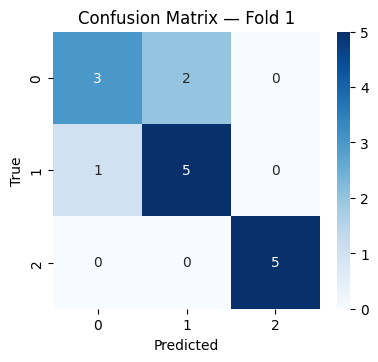


[cv] Fold 2/5 — train=63 val=16
      [epoch 01] train_loss=1.0488 val_acc=0.625
      [epoch 02] train_loss=0.7564 val_acc=0.750
      [epoch 03] train_loss=0.6092 val_acc=0.812
      [epoch 04] train_loss=0.5635 val_acc=0.812
      [epoch 05] train_loss=0.4928 val_acc=0.812
      [epoch 06] train_loss=0.4933 val_acc=0.875
      [epoch 07] train_loss=0.4467 val_acc=0.875
      [epoch 08] train_loss=0.4753 val_acc=0.812
      [epoch 09] train_loss=0.4702 val_acc=0.812
      [epoch 10] train_loss=0.4804 val_acc=0.812
      [epoch 11] train_loss=0.5032 val_acc=0.875
      [epoch 12] train_loss=0.4784 val_acc=0.875
      [epoch 13] train_loss=0.4004 val_acc=0.812
      [epoch 14] train_loss=0.4113 val_acc=0.875
      [epoch 15] train_loss=0.4013 val_acc=0.875
[metrics][fold 2] MAE=0.125 QWK=0.900 ACC=0.875 RHO=0.913 ECE=0.155
[compare][fold 2] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317


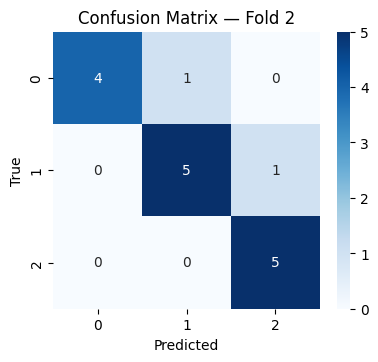


[cv] Fold 3/5 — train=63 val=16
      [epoch 01] train_loss=1.0748 val_acc=0.750
      [epoch 02] train_loss=0.7959 val_acc=0.812
      [epoch 03] train_loss=0.6372 val_acc=0.812
      [epoch 04] train_loss=0.5890 val_acc=0.812
      [epoch 05] train_loss=0.5123 val_acc=0.875
      [epoch 06] train_loss=0.4843 val_acc=0.750
      [epoch 07] train_loss=0.5058 val_acc=0.812
      [epoch 08] train_loss=0.5274 val_acc=0.875
      [epoch 09] train_loss=0.4636 val_acc=0.750
      [epoch 10] train_loss=0.4586 val_acc=0.812
      [epoch 11] train_loss=0.4530 val_acc=0.875
      [epoch 12] train_loss=0.4157 val_acc=0.875
      [epoch 13] train_loss=0.4473 val_acc=0.875
      [epoch 14] train_loss=0.4802 val_acc=0.812
      [epoch 15] train_loss=0.5196 val_acc=0.875
[metrics][fold 3] MAE=0.125 QWK=0.889 ACC=0.875 RHO=0.916 ECE=0.191
[compare][fold 3] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317


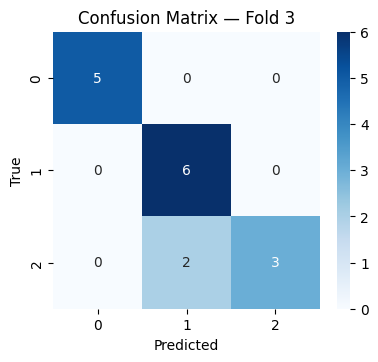


[cv] Fold 4/5 — train=63 val=16
      [epoch 01] train_loss=0.9893 val_acc=0.688
      [epoch 02] train_loss=0.6931 val_acc=0.750
      [epoch 03] train_loss=0.5287 val_acc=0.625
      [epoch 04] train_loss=0.5451 val_acc=0.750
      [epoch 05] train_loss=0.4828 val_acc=0.688
      [epoch 06] train_loss=0.4845 val_acc=0.688
      [epoch 07] train_loss=0.4361 val_acc=0.688
      [epoch 08] train_loss=0.4026 val_acc=0.688
      [epoch 09] train_loss=0.4428 val_acc=0.750
      [epoch 10] train_loss=0.4199 val_acc=0.688
      [epoch 11] train_loss=0.4462 val_acc=0.750
      [epoch 12] train_loss=0.4037 val_acc=0.688
      [epoch 13] train_loss=0.3472 val_acc=0.750
      [epoch 14] train_loss=0.3614 val_acc=0.688
      [epoch 15] train_loss=0.3784 val_acc=0.750
[metrics][fold 4] MAE=0.250 QWK=0.800 ACC=0.750 RHO=0.800 ECE=0.231
[compare][fold 4] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317


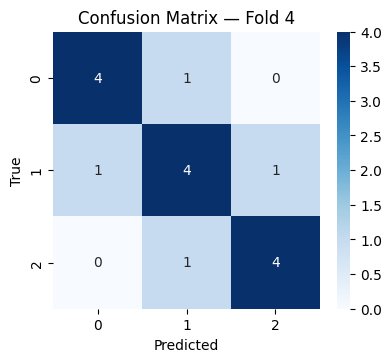


[cv] Fold 5/5 — train=64 val=15
      [epoch 01] train_loss=1.0057 val_acc=0.533
      [epoch 02] train_loss=0.7132 val_acc=0.733
      [epoch 03] train_loss=0.5772 val_acc=0.733
      [epoch 04] train_loss=0.5273 val_acc=0.733
      [epoch 05] train_loss=0.4954 val_acc=0.667
      [epoch 06] train_loss=0.4864 val_acc=0.800
      [epoch 07] train_loss=0.4791 val_acc=0.733
      [epoch 08] train_loss=0.4464 val_acc=0.733
      [epoch 09] train_loss=0.4247 val_acc=0.800
      [epoch 10] train_loss=0.4315 val_acc=0.733
      [epoch 11] train_loss=0.3931 val_acc=0.800
      [epoch 12] train_loss=0.4333 val_acc=0.733
      [epoch 13] train_loss=0.3936 val_acc=0.800
      [epoch 14] train_loss=0.3946 val_acc=0.733
      [epoch 15] train_loss=0.3755 val_acc=0.800
[metrics][fold 5] MAE=0.200 QWK=0.870 ACC=0.800 RHO=0.879 ECE=0.268
[compare][fold 5] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317


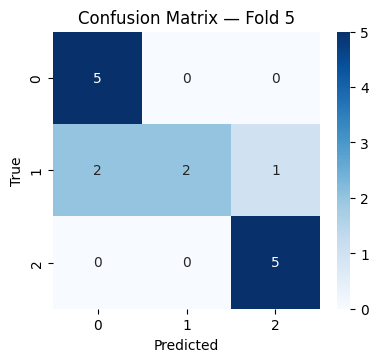


[cv] Summary (mean ± std):
    MAE: 0.177 ± 0.053
    QWK: 0.860 ± 0.040
    ACC: 0.823 ± 0.053
    RHO: 0.872 ± 0.048
    ECE: 0.209 ± 0.043

[done] Pipeline execution complete.


In [10]:

if __name__ == "__main__":
    main()

In [11]:
# === ZIP ALL CACHED .NPZ FILES ===
import os, glob, zipfile, datetime

# If you already have this defined earlier, reuse it:
CACHE_DIR = globals().get("CACHE_DIR", "/kaggle/working/cache_npz")  # <-- set to your cache folder
os.makedirs(CACHE_DIR, exist_ok=True)

# Name the zip with timestamp to avoid overwriting
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ZIP_PATH = f"/kaggle/working/cached_features_{stamp}.zip"

npz_files = sorted(glob.glob(os.path.join(CACHE_DIR, "*.npz")))
if not npz_files:
    raise FileNotFoundError(f"No .npz found in {CACHE_DIR}. Did you run the feature-caching step?")

with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in npz_files:
        zf.write(p, arcname=os.path.basename(p))

print(f"[zip] Created: {ZIP_PATH}")
print("Download from the right-side 'Files' panel (kaggle/working).")


[zip] Created: /kaggle/working/cached_features_20251004-140312.zip
Download from the right-side 'Files' panel (kaggle/working).


In [19]:
# === FINAL MODEL: LOAD LABELS & ALIGN WITH CACHE (.npz) ===
import os, glob
import numpy as np
import pandas as pd
from collections import Counter

# ---- Paths (adjust LABELS_CSV if your CSV lives elsewhere) ----
LABELS_CSV = "/kaggle/input/interview-videos/labels_filenames_only.csv"  # your CSV with video_filename, score

# Prefer an existing cache dir automatically
CACHE_CANDIDATES = [
    globals().get("CACHE_DIR", None),
    "/kaggle/working/cache",          # <- you have this one
    "/kaggle/working/cache_npz",
]
CACHE_DIR = None
for c in CACHE_CANDIDATES:
    if c and os.path.isdir(c) and glob.glob(os.path.join(c, "*.npz")):
        CACHE_DIR = c
        break
if not CACHE_DIR:
    raise FileNotFoundError("No cache dir with .npz found. Expected /kaggle/working/cache or set CACHE_DIR before this cell.")

print(f"[paths] LABELS_CSV={LABELS_CSV}")
print(f"[paths] CACHE_DIR ={CACHE_DIR}")

# ---- Read labels ----
FN_COL = "video_filename"
LB_COL = "score"

labels_df = pd.read_csv(LABELS_CSV)
if FN_COL not in labels_df.columns or LB_COL not in labels_df.columns:
    raise KeyError(f"CSV must contain '{FN_COL}' and '{LB_COL}'. Found: {list(labels_df.columns)}")

# normalize names we will use for matching
def _base(s):  # basename with ext, lower
    return os.path.basename(str(s)).lower().strip()
def _stem(s):  # basename without ext, lower
    return os.path.splitext(_base(s))[0]

labels_df = labels_df.copy()
labels_df["__base__"]  = labels_df[FN_COL].apply(_base)
labels_df["__stem__"]  = labels_df[FN_COL].apply(_stem)

# numeric labels; if they are 1..3, map to 0..2
labels_df[LB_COL] = pd.to_numeric(labels_df[LB_COL], errors="coerce")
if labels_df[LB_COL].isna().any():
    raise ValueError(f"Non-numeric values in '{LB_COL}'. Please clean the CSV.")
y_series = labels_df[LB_COL].astype(int)
if sorted(y_series.unique().tolist()) == [1,2,3]:
    y_series = y_series - 1
labels_df["__label__"] = y_series

# ---- Build a cache map (prefer base files; ignore augmented ones unless needed) ----
npz_paths = glob.glob(os.path.join(CACHE_DIR, "*.npz"))
if not npz_paths:
    raise FileNotFoundError(f"No .npz in {CACHE_DIR}")

# create two dicts:
#   exact_base_map: 'anjaly_1.npz' -> vector (prefer this when we have exact base)
#   stem_first_map: 'anjaly_1'     -> vector (fallback: choose the NON-aug file if present, else first match)
exact_base_map = {}
stem_bucket = {}

for p in npz_paths:
    base = os.path.basename(p).lower()
    stem = os.path.splitext(base)[0]
    if stem not in stem_bucket:
        stem_bucket[stem] = []
    stem_bucket[stem].append(p)
    exact_base_map[base] = p

def choose_npz_for_stem(stem: str):
    """Prefer exact '<stem>.npz' (original). If not found, fallback to first non-'_aug' file, else first available."""
    exact = exact_base_map.get(f"{stem}.npz")
    if exact:
        return exact
    candidates = stem_bucket.get(stem, [])
    if not candidates:
        return None
    non_aug = [p for p in candidates if "_aug" not in os.path.basename(p)]
    return (non_aug[0] if non_aug else candidates[0])

# ---- Align labels to fused vectors ----
X_list, y_list, used, missing = [], [], [], []
for _, row in labels_df.iterrows():
    base, stem, lab = row["__base__"], row["__stem__"], int(row["__label__"])
    p = exact_base_map.get(f"{stem}.npz")
    if p is None:
        p = choose_npz_for_stem(stem)
    if p is None:
        missing.append(row[FN_COL])
        continue
    vec = np.load(p, allow_pickle=True)["fused"].astype("float32")
    X_list.append(vec)
    y_list.append(lab)
    used.append(row[FN_COL])

if missing:
    print(f"[warn] {len(missing)} label rows had no matching cache. Examples: {missing[:10]}")
    print("Tip: ensure cache filenames are stems of your CSV 'video_filename' (e.g., anjaly_1.npz ↔ anjaly_1.mp4).")

if not X_list:
    raise RuntimeError("No labels matched any cached .npz files. Check filename conventions and cache dir.")

X = np.vstack(X_list).astype("float32")
y = np.array(y_list, dtype="int64")
n_classes = len(sorted(set(y)))
print(f"[data] X: {X.shape}, y: {y.shape}, classes: {sorted(set(y))}")
print(f"[data] class counts: {Counter(y)}")


[paths] LABELS_CSV=/kaggle/input/interview-videos/labels_filenames_only.csv
[paths] CACHE_DIR =/kaggle/working/cache
[data] X: (79, 1536), y: (79,), classes: [0, 1, 2]
[data] class counts: Counter({1: 29, 2: 25, 0: 25})


In [20]:
# === TRAIN FINAL MLP ON ALL DATA & SAVE ARTIFACTS ===
import json, torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

SAVE_DIR       = "/kaggle/working"
FINAL_MODEL    = os.path.join(SAVE_DIR, "final_mlp.pt")
FINAL_CONFIG   = os.path.join(SAVE_DIR, "final_config.json")
FINAL_CLASSMAP = os.path.join(SAVE_DIR, "class_map.json")

BATCH_SIZE   = 16
EPOCHS       = 20       # we will keep best by loss
LR           = 1e-3
WEIGHT_DECAY = 1e-2
HIDDEN_DIM   = 512
DROPOUT      = 0.30
SEED         = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[env] device={DEVICE}")

def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(SEED)

# MLP Head (same as CV head)
class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden=HIDDEN_DIM, num_classes=3, p=DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# Dataset/DataLoader
ds_all = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
loader = DataLoader(ds_all, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# Optional: class weights
counts = np.bincount(y, minlength=n_classes)
weights = counts.sum() / np.maximum(counts, 1)
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
print(f"[train] class_weights={class_weights.cpu().numpy().round(3).tolist()}")

# Train
model = MLPHead(in_dim=X.shape[1], hidden=HIDDEN_DIM, num_classes=n_classes, p=DROPOUT).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit  = nn.CrossEntropyLoss(weight=class_weights)

best_loss = float("inf")
best_state = None

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss, total_correct, total_seen = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()

        total_loss   += loss.item() * yb.size(0)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total_seen   += yb.size(0)

    train_loss = total_loss / max(total_seen,1)
    train_acc  = total_correct / max(total_seen,1)
    print(f"[final-train] epoch {epoch:02d}/{EPOCHS} | loss={train_loss:.4f} acc={train_acc:.4f}")

    if train_loss < best_loss:
        best_loss = train_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

# keep best-by-loss
if best_state is not None:
    model.load_state_dict(best_state)

# Save model + config + class map
save_obj = {
    "state_dict": model.state_dict(),
    "in_dim": int(X.shape[1]),
    "hidden_dim": int(HIDDEN_DIM),
    "num_classes": int(n_classes),
    "dropout": float(DROPOUT),
}
torch.save(save_obj, FINAL_MODEL)
print(f"[save] model -> {FINAL_MODEL}")

class_map = {int(i): f"class_{int(i)}" for i in sorted(set(y))}
with open(FINAL_CLASSMAP, "w") as f:
    json.dump(class_map, f, indent=2)
print(f"[save] class_map -> {FINAL_CLASSMAP}")

config = {
    "CACHE_DIR": CACHE_DIR,
    "LABELS_CSV": LABELS_CSV,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "LR": LR,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "HIDDEN_DIM": HIDDEN_DIM,
    "DROPOUT": DROPOUT,
    "SEED": SEED,
    "DEVICE": DEVICE,
}
with open(FINAL_CONFIG, "w") as f:
    json.dump(config, f, indent=2)
print(f"[save] final_config -> {FINAL_CONFIG}")

print("\n[done] Artifacts saved in /kaggle/working — use the right Files panel to download.")


[env] device=cuda
[train] class_weights=[1.0479999780654907, 0.9039999842643738, 1.0479999780654907]
[final-train] epoch 01/20 | loss=1.0350 acc=0.4684
[final-train] epoch 02/20 | loss=0.8113 acc=0.6203
[final-train] epoch 03/20 | loss=0.6453 acc=0.6962
[final-train] epoch 04/20 | loss=0.5670 acc=0.7595
[final-train] epoch 05/20 | loss=0.5167 acc=0.7722
[final-train] epoch 06/20 | loss=0.5393 acc=0.7089
[final-train] epoch 07/20 | loss=0.4857 acc=0.8101
[final-train] epoch 08/20 | loss=0.4457 acc=0.7848
[final-train] epoch 09/20 | loss=0.4418 acc=0.8101
[final-train] epoch 10/20 | loss=0.4564 acc=0.7722
[final-train] epoch 11/20 | loss=0.4388 acc=0.8101
[final-train] epoch 12/20 | loss=0.4276 acc=0.7848
[final-train] epoch 13/20 | loss=0.4065 acc=0.8228
[final-train] epoch 14/20 | loss=0.4084 acc=0.8228
[final-train] epoch 15/20 | loss=0.4046 acc=0.8228
[final-train] epoch 16/20 | loss=0.3838 acc=0.8481
[final-train] epoch 17/20 | loss=0.4156 acc=0.7975
[final-train] epoch 18/20 | loss

In [21]:
# === ZIP FINAL MODEL ARTIFACTS ===
import zipfile, datetime

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
BUNDLE_ZIP = f"/kaggle/working/final_model_bundle_{stamp}.zip"

with zipfile.ZipFile(BUNDLE_ZIP, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in [FINAL_MODEL, FINAL_CONFIG, FINAL_CLASSMAP]:
        if os.path.exists(p):
            zf.write(p, arcname=os.path.basename(p))
print(f"[zip] Created: {BUNDLE_ZIP}")
print("Download from the right-side 'Files' panel.")


[zip] Created: /kaggle/working/final_model_bundle_20251004-142734.zip
Download from the right-side 'Files' panel.


In [22]:
# === ROBUST INFERENCE SMOKE TEST ===
import os, glob, json, torch, numpy as np
import torch.nn as nn

def find_model_path():
    pref = "/kaggle/working/final_mlp.pt"
    if os.path.exists(pref): return pref
    candidates = sorted(glob.glob("/kaggle/working/*.pt") + glob.glob("/kaggle/working/*.pth"),
                        key=os.path.getmtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No model file found in /kaggle/working. Run the training cell first.")
    return candidates[0]

def find_one_npz():
    # prefer the chosen CACHE_DIR
    if os.path.isdir(CACHE_DIR):
        picks = glob.glob(os.path.join(CACHE_DIR, "*.npz"))
        if picks: return sorted(picks)[0]
    # fallback search
    picks = sorted(glob.glob("/kaggle/working/**/*.npz", recursive=True))
    if not picks:
        raise FileNotFoundError("No .npz found under /kaggle/working. Build cache first.")
    return picks[0]

MODEL_PATH = find_model_path()
ckpt = torch.load(MODEL_PATH, map_location="cpu")
in_dim      = int(ckpt["in_dim"])
hidden_dim  = int(ckpt["hidden_dim"])
num_classes = int(ckpt["num_classes"])
dropout     = float(ckpt.get("dropout", 0.3))

class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden, num_classes, p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x): return self.net(x)

model = MLPHead(in_dim, hidden_dim, num_classes, p=dropout)
model.load_state_dict(ckpt["state_dict"], strict=True)
model.eval()

# optional class map
CLASSMAP_JS = "/kaggle/working/class_map.json"
if os.path.exists(CLASSMAP_JS):
    try:
        with open(CLASSMAP_JS, "r") as f:
            tmp = json.load(f)
        class_map = {int(k): v for k, v in tmp.items()}
    except Exception:
        class_map = {i: f"class_{i}" for i in range(num_classes)}
else:
    class_map = {i: f"class_{i}" for i in range(num_classes)}

sample_npz = find_one_npz()
vec = np.load(sample_npz, allow_pickle=True)["fused"].astype("float32")
x = torch.from_numpy(vec).unsqueeze(0)

with torch.no_grad():
    logits = model(x)
    prob = torch.softmax(logits, dim=1).squeeze(0).numpy()
    pred = int(prob.argmax())

print(f"[inference] model={os.path.basename(MODEL_PATH)} | sample={os.path.basename(sample_npz)}")
print(f"           pred={pred} ({class_map.get(pred, pred)}) | probs={np.round(prob,3)}")


[inference] model=final_mlp.pt | sample=anjaly_1.npz
           pred=1 (class_1) | probs=[0.004 0.565 0.432]
